In [1]:
from griblib import CERRA
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import xarray as xr

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [27]:
from plot_defaults import *

### MPL defaults

dpi_fig = 600
base = 15
plt.rcParams.update({
    "font.size": base,
    "axes.labelsize": base,
    "axes.titlesize": base + 1,     # was 13
    "axes.labelpad": 10,            # 12 is fine too
    "xtick.labelsize": base - 2,    # 14
    "ytick.labelsize": base - 2,    # 14
    "legend.fontsize": base - 3,    # 13 (instead of 11)
    "figure.titlesize": base + 2,   # 18 (instead of 14)
})

In [4]:
# plotting parameters
temp_lim = {'min': -10.0, 'max': 30.0}
#temp_lim = {'min': -50.0, 'max': 0.0}
wind_lim = {'min': 5.0, 'max': 20.0}
z_lim = {'min': 0.0, 'max': 10.0, 'dz': 1.0}

# parameters for great circle path
path_params = dict()
path_params['type'] = 'coordinates'
path_params['start'] = dict(lat=50.4, lon=1.0)
path_params['end'] = dict(lat=52.4, lon=6.4)
#path_params['type'] = 'range-azimuth'
#path_params['start'] = dict(lat=51.0, lon=0.0)
#path_params['range'] = 700.0e3
#path_params['azimuth'] = 60.0
dr = 1.0e3

In [42]:
import glob

In [6]:
my_atmos = CERRA(cycle='43')

In [29]:
fid_grib = 'cerra/CERRA_20220630-03.ml.grib'
request = [ {'level_type': 'hybrid'} ]
ds_ml = my_atmos.read_grib(fid_grib, request, compat='override')
ds_ml

********************************************************************************
Reading CERRA cy43 GRIB file [ cerra/CERRA_20220630-03.ml.grib ]

Reading GRIB PV coefficients
Reading all variables on hybrid level


<xarray.Dataset> Size: 2GB
Dimensions:     (hybrid: 106, y: 1069, x: 1069)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
  * hybrid      (hybrid) float64 848B 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0
    latitude    (y, x) float64 9MB ...
    longitude   (y, x) float64 9MB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    q           (hybrid, y, x) float32 485MB ...
    t           (hybrid, y, x) float32 485MB ...
    u           (hybrid, y, x) float32 485MB ...
    v           (hybrid, y, x) float32 485MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2026-02-16T21:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [30]:
fid_grib = 'cerra/CERRA_20220630-03.sfc.grib'
request = [ {'level_type': 'surface'} ]
ds_sfc = my_atmos.read_grib(fid_grib, request, compat='override')
ds_sfc

********************************************************************************
Reading CERRA cy43 GRIB file [ cerra/CERRA_20220630-03.sfc.grib ]

Reading GRIB PV coefficients
Reading all variables on surface level


<xarray.Dataset> Size: 27MB
Dimensions:     (y: 1069, x: 1069)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 9MB ...
    longitude   (y, x) float64 9MB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    orog        (y, x) float32 5MB ...
    sp          (y, x) float32 5MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2026-02-16T21:42 GRIB to CDM+CF via cfgrib-0.9.1...

#### Modifications so we can compute height and pressure on hybrid level later

In [31]:
# Rename 'sp' -> 'pres'
try:
    ds_sfc = ds_sfc.rename({"sp": "pres"})
except Exception as e:
    print(e)
    pass

# Compute geopotential from orography
g0 = 9.80665  # m s-2
ds_sfc["z"] = g0 * ds_sfc["orog"]

ds_sfc["z"].attrs.update({
    "units": "m**2 s**-2",
    "long_name": "Surface geopotential",
    "standard_name": "surface_geopotential",
    "comment": "Computed as Φ = g0 * orography height"
})

ds_sfc

<xarray.Dataset> Size: 32MB
Dimensions:     (y: 1069, x: 1069)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    latitude    (y, x) float64 9MB ...
    longitude   (y, x) float64 9MB ...
    valid_time  datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    orog        (y, x) float32 5MB 0.9846 -1.39 0.2346 ... 111.4 109.1 104.6
    pres        (y, x) float32 5MB ...
    z           (y, x) float32 5MB 9.656 -13.63 2.301 ... 1.07e+03 1.026e+03
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2026-02-16T21:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [32]:
ds_raw = xr.merge([ds_ml, ds_sfc], compat="override", join="exact")
ds_raw

<xarray.Dataset> Size: 2GB
Dimensions:     (hybrid: 106, y: 1069, x: 1069)
Coordinates:
    time        datetime64[ns] 8B ...
    step        timedelta64[ns] 8B ...
  * hybrid      (hybrid) float64 848B 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0
    latitude    (y, x) float64 9MB ...
    longitude   (y, x) float64 9MB ...
    valid_time  datetime64[ns] 8B ...
    surface     float64 8B ...
Dimensions without coordinates: y, x
Data variables:
    q           (hybrid, y, x) float32 485MB ...
    t           (hybrid, y, x) float32 485MB ...
    u           (hybrid, y, x) float32 485MB ...
    v           (hybrid, y, x) float32 485MB ...
    orog        (y, x) float32 5MB 0.9846 -1.39 0.2346 ... 111.4 109.1 104.6
    pres        (y, x) float32 5MB ...
    z           (y, x) float32 5MB 9.656 -13.63 2.301 ... 1.07e+03 1.026e+03
Attributes:
    GRIB_edition:            2
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Norrkoping
    history:                 2026-02-16T21:42 GRIB to CDM+CF via cfgrib-0.9.1...

In [33]:
def add_altitude_pressure_density(self, ds):
    # compute pressure, geopotential and geometric altitudes on model levels

    (z, pres) = self.compute_altitude_pressure(t=ds.t,
                                                q=ds.q,
                                                ps=ds.pres,
                                                z0=ds.z)
    dens = self.compute_density(pres, ds.t)
    ds = ds.drop_vars(['z', 'pres'])
    ds = xr.merge([z.to_dataset(), pres.to_dataset(), dens.to_dataset(), ds])
    return ds

ds_raw = add_altitude_pressure_density(my_atmos, ds_raw)
ds_raw

<xarray.Dataset> Size: 5GB
Dimensions:     (hybrid: 106, y: 1069, x: 1069)
Coordinates:
    time        datetime64[ns] 8B 2022-06-30T03:00:00
    step        timedelta64[ns] 8B 00:00:00
  * hybrid      (hybrid) float64 848B 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0
    latitude    (y, x) float64 9MB 20.29 20.31 20.32 20.34 ... 63.84 63.81 63.77
    longitude   (y, x) float64 9MB 342.5 342.6 342.6 342.6 ... 73.97 74.04 74.11
    valid_time  datetime64[ns] 8B 2022-06-30T03:00:00
    surface     float64 8B 0.0
Dimensions without coordinates: y, x
Data variables:
    z           (hybrid, y, x) float64 969MB 4.842e+04 4.842e+04 ... 119.5 115.0
    pres        (hybrid, y, x) float64 969MB 100.0 100.0 ... 9.855e+04 9.86e+04
    den         (hybrid, y, x) float64 969MB 0.001346 0.001346 ... 1.198 1.199
    q           (hybrid, y, x) float32 485MB 1.251e-05 1.25e-05 ... 0.007142
    t           (hybrid, y, x) float32 485MB 258.9 258.9 258.9 ... 286.5 286.5
    u           (hybrid, y, x) float32 485MB ...
    v           (hybrid, y, x) float32 485MB ...
    orog        (y, x) float32 5MB 0.9846 -1.39 0.2346 ... 111.4 109.1 104.6

In [34]:
# Constant of specific heat constants
gamma = 1.4
# Gas constant for an ideal gas (J/K/mol)
R = 8.31451
# Molar mass dry air and water vapor
m_air = 28.9644E-3
m_wet = 18.0153E-3
# Gas constants for dry air / water vapor J/(kg*K)
R_dry = R / m_air
R_wet = R / m_wet

# Gravitational acceleration constant (m/s^2)
g = 9.80655
cp = 1005  # J/(kg*K)

def compute_potential_temperature(self, ds):
    p0 = ds.pres.sel(hybrid=len(ds.hybrid))
    ds['theta'] = ds['t'] * ( p0 / ds['pres'])**(R_dry/cp)
    ds['theta'].attrs={'long_name': 'Potential temperature',
                        'units' : 'K',
                        'standard_name': 'theta'}
    return ds

ds_raw = compute_potential_temperature(my_atmos, ds_raw)
ds_raw

<xarray.Dataset> Size: 6GB
Dimensions:     (hybrid: 106, y: 1069, x: 1069)
Coordinates:
    time        datetime64[ns] 8B 2022-06-30T03:00:00
    step        timedelta64[ns] 8B 00:00:00
  * hybrid      (hybrid) float64 848B 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0
    latitude    (y, x) float64 9MB 20.29 20.31 20.32 20.34 ... 63.84 63.81 63.77
    longitude   (y, x) float64 9MB 342.5 342.6 342.6 342.6 ... 73.97 74.04 74.11
    valid_time  datetime64[ns] 8B 2022-06-30T03:00:00
    surface     float64 8B 0.0
Dimensions without coordinates: y, x
Data variables:
    z           (hybrid, y, x) float64 969MB 4.842e+04 4.842e+04 ... 119.5 115.0
    pres        (hybrid, y, x) float64 969MB 100.0 100.0 ... 9.855e+04 9.86e+04
    den         (hybrid, y, x) float64 969MB 0.001346 0.001346 ... 1.198 1.199
    q           (hybrid, y, x) float32 485MB 1.251e-05 1.25e-05 ... 0.007142
    t           (hybrid, y, x) float32 485MB 258.9 258.9 258.9 ... 286.5 286.5
    u           (hybrid, y, x) float32 485MB ...
    v           (hybrid, y, x) float32 485MB ...
    orog        (y, x) float32 5MB 0.9846 -1.39 0.2346 ... 111.4 109.1 104.6
    theta       (hybrid, y, x) float64 969MB 1.867e+03 1.868e+03 ... 286.5 286.5

### Reinterpolate onto regular lat-lon grid

In [35]:
import numpy as np
import xarray as xr
import xesmf as xe

# target lat/lon arrays
lat_new = np.arange(49.5, 54.0, 0.05)
lon_new = np.arange(1.0, 8.0, 0.05)

target_grid = xr.Dataset({
    'latitude': (['latitude'], lat_new),
    'longitude': (['longitude'], lon_new)
})

In [36]:
regridder = xe.Regridder(ds_raw, target_grid, method='bilinear', reuse_weights=False)
ds = regridder(ds_raw)  # returns a new Dataset on regular lat/lon

In [37]:
ds

<xarray.Dataset> Size: 64MB
Dimensions:     (hybrid: 106, latitude: 90, longitude: 140)
Coordinates:
    time        datetime64[ns] 8B 2022-06-30T03:00:00
    step        timedelta64[ns] 8B 00:00:00
  * hybrid      (hybrid) float64 848B 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0
    valid_time  datetime64[ns] 8B 2022-06-30T03:00:00
    surface     float64 8B 0.0
  * latitude    (latitude) float64 720B 49.5 49.55 49.6 ... 53.85 53.9 53.95
  * longitude   (longitude) float64 1kB 1.0 1.05 1.1 1.15 ... 7.8 7.85 7.9 7.95
Data variables:
    z           (hybrid, latitude, longitude) float64 11MB 4.936e+04 ... 10.38
    pres        (hybrid, latitude, longitude) float64 11MB 100.0 ... 1.012e+05
    den         (hybrid, latitude, longitude) float64 11MB 0.001297 ... 1.204
    q           (hybrid, latitude, longitude) float32 5MB 2.716e-05 ... 0.009827
    t           (hybrid, latitude, longitude) float32 5MB 268.6 268.6 ... 292.8
    u           (hybrid, latitude, longitude) float32 5MB -26.04 ... -6.295
    v           (hybrid, latitude, longitude) float32 5MB -1.182 ... 3.777
    orog        (latitude, longitude) float32 50kB 106.2 110.7 ... -0.2626
    theta       (hybrid, latitude, longitude) float64 11MB 1.931e+03 ... 292.8
Attributes:
    regrid_method:  bilinear

In [38]:
ds_gcp = my_atmos.extract_gcp_slice(ds, path_params, dr=dr)

In [39]:
ds_gcp

<xarray.Dataset> Size: 3MB
Dimensions:     (hybrid: 106, distance: 438)
Coordinates:
    time        datetime64[ns] 8B 2022-06-30T03:00:00
    step        timedelta64[ns] 8B 00:00:00
  * hybrid      (hybrid) float64 848B 1.0 2.0 3.0 4.0 ... 104.0 105.0 106.0
    valid_time  datetime64[ns] 8B 2022-06-30T03:00:00
    surface     float64 8B 0.0
    longitude   (distance) float64 4kB 1.0 1.012 1.024 1.035 ... 6.374 6.387 6.4
    latitude    (distance) float64 4kB 50.4 50.4 50.41 50.41 ... 52.39 52.4 52.4
  * distance    (distance) float64 4kB 0.0 999.0 ... 4.356e+05 4.366e+05
    azimuth     (distance) float64 4kB 57.27 57.28 57.29 ... 61.47 61.48 61.49
Data variables:
    z           (hybrid, distance) float64 371kB 4.94e+04 4.94e+04 ... 21.91
    pres        (hybrid, distance) float64 371kB 100.0 100.0 ... 1.009e+05
    den         (hybrid, distance) float64 371kB 0.001291 0.001291 ... 1.208
    q           (hybrid, distance) float64 371kB 2.956e-05 2.959e-05 ... 0.01009
    t           (hybrid, distance) float64 371kB 269.8 269.8 ... 291.0 291.0
    u           (hybrid, distance) float64 371kB -25.59 -25.6 ... -2.864 -2.877
    v           (hybrid, distance) float64 371kB 0.4729 0.4719 ... 0.7015 0.6867
    orog        (distance) float64 4kB 0.1286 0.1038 0.09723 ... 11.27 11.33
    theta       (hybrid, distance) float64 371kB 1.947e+03 1.947e+03 ... 291.0
Attributes:
    regrid_method:  bilinear

### Plot potential temperature and wind along path

In [40]:
import pandas as pd
from griblib.utils.geo import inverse_transform


# plotting parameters #################
temp_lim = {'min': 5.0, 'max': 20.0}
#temp_lim = {'min': -50.0, 'max': 0.0}
wind_lim = {'min': -10.0, 'max': 10.0}
w_lim = {'min': -0.5, 'max': 0.5}
z_lim = {'min': 0.0, 'max': 5.0, 'dz': 1.0}
rain_lim = {'min': 1e-3, 'max': 100 }
#######################################

mbarometers = pd.DataFrame(
    {'Site': ['NL.CIA'],
    'Location': ['Cabauw'],
    'Latitude': [51.968840],
    'Longitude': [4.927930]
    }
    )

white_stroke = [pe.Stroke(linewidth=2, foreground="white", alpha=0.5),
                pe.Normal()]

def plot_prefix(self, ds_gcp):
    t_fcst = (ds_gcp.valid_time).dt.strftime('%Y%m%d-%H').values
    lons = ds_gcp.longitude.values
    lats = ds_gcp.latitude.values
    coord_str = '({slo:.1f}E, {sla:.1f}N) > ({elo:.1f}E, {ela:.1f}N)'.format(
        slo=lons[0], sla=lats[0], elo=lons[-1], ela=lats[-1])
    title_str = f'{self.model} analysis {t_fcst} UTC\n{coord_str}'

    fid_prefix = '{model}{cycle}_{time}'.format(model=self.model, 
                                                cycle=self.cycle, 
                                                time=t_fcst)
    return (t_fcst, title_str, fid_prefix)

def plot_gcp_gw(self, ds_gcp):
    (_, title_str, fid_prefix) = plot_prefix(self, ds_gcp)
    nlev = ds_gcp.sizes['hybrid']
    nrng = ds_gcp.sizes['distance']

    x = np.broadcast_to(np.expand_dims(ds_gcp.distance, axis=0), shape=(nlev, nrng)) / 1e3
    y = ds_gcp.z / 1e3

    # Wind along track
    wa = np.sin(np.deg2rad(ds_gcp.azimuth))*ds_gcp.u + np.cos(np.deg2rad(ds_gcp.azimuth))*ds_gcp.v
    wa = wa.squeeze()

    n_frames = 2
    fig, ax = plt.subplots(n_frames, 1, sharex=True, sharey=True, figsize=(6,5))
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.15, hspace=0.15)

    i = 0
    # Temperature
    z = ds_gcp['theta']
    im = ax[i].pcolormesh(x, y, ds_gcp['theta'],
                          vmin=290, vmax=305,
                          cmap='coolwarm', shading='auto')
    plt.colorbar(im, ax=ax[i], label=r'$\theta$ (K)')
    # Temperature perturbation
    # im = ax[i].pcolormesh(x, y, temperature,
    #             cmap='RdBu_r', shading='gouraud',
    #             vmin=-2, vmax=2)
    # plt.colorbar(im, ax=ax[i], label='dT [deg C]')

    # Horizontal wind
    i += 1 
    im = ax[i].pcolormesh(x, y, wa.T,
                cmap='RdBu_r', shading='auto',
                vmin=wind_lim['min'], vmax=wind_lim['max'])
    plt.colorbar(im, ax=ax[i], label='Along-track wind (m/s)')

    for i in range(0,n_frames):
        ax[i].set_title('')
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Altitude (km)')
        ax[i].set_ylim(z_lim['min'], z_lim['max'])
        ax[i].set_yticks(np.arange(z_lim['min'], z_lim['max'], z_lim['dz']))

        for idx, row in mbarometers.iterrows():
            _pt = dict(lat=row.Latitude, lon=row.Longitude)
            _start = dict(lat=ds_gcp.latitude.data[0], lon=ds_gcp.longitude.data[0])
            (_,_,_dist) = inverse_transform(start=_start, end=_pt)
            ax[i].axvline(x=_dist/1e3, linewidth=1.0, color='black', linestyle=':',
                          path_effects=white_stroke)
            #ax[i].scatter(_dist/1e3, 0.0, s=300, marker='^', c='red', alpha=0.2, edgecolors='black')

        #ax[i].grid(linestyle=':')

    plt.tight_layout

    ax[0].set_title(title_str)
    ax[n_frames-1].set_xlabel('Distance, km')

    #plt.show()
    # fid = f'{fid_prefix}_gcp_gw_ml.png'
    # fig.savefig(fid, facecolor='white', bbox_inches = 'tight', dpi=300)
    fid = f'{fid_prefix}_gcp_gw_ml.png'
    fig.savefig(fid, facecolor='white', bbox_inches = 'tight', dpi=600)
    #fig.savefig('../'+fid, facecolor='white', bbox_inches = 'tight')
    return fig, ax

/var/folders/5q/0ps0ffm53hzdn0xrj02n69nh0000gn/T/ipykernel_1559/3445467873.py:57: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[i].pcolormesh(x, y, ds_gcp['theta'],
/var/folders/5q/0ps0ffm53hzdn0xrj02n69nh0000gn/T/ipykernel_1559/3445467873.py:69: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax[i].pcolormesh(x, y, wa.T,


(<Figure size 600x500 with 4 Axes>,
 array([<Axes: title={'center': 'CERRA analysis 20220630-03 UTC\n(1.0E, 50.4N) > (6.4E, 52.4N)'}, ylabel='Altitude (km)'>,
        <Axes: xlabel='Distance, km', ylabel='Altitude (km)'>],
       dtype=object))

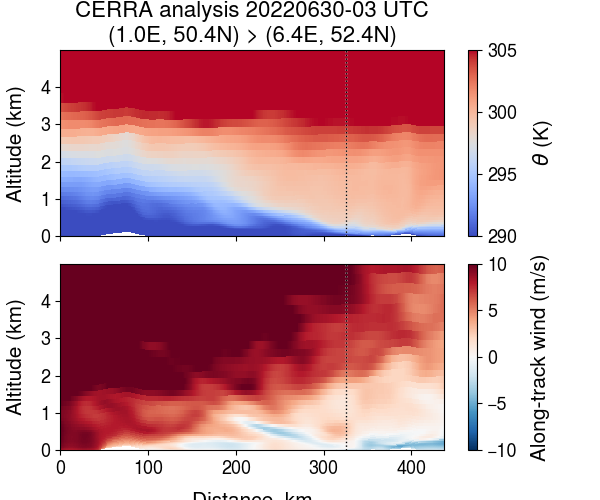

In [41]:
plot_gcp_gw(my_atmos, ds_gcp)